In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

In [14]:
def reduce(inp, dimension_mapping, compression_type):
    ''' Reduces an input along one or more dimensions by computing the 
        maximum or sum along these dimensions. 

        Parameters
        ----------
        inp : array_like
            input whose dimensions should be reduced
        dimension_mapping : dict
            Maps input dimensions to output dimensions. If a dimension is
            mapped to False it should be removed
        compression_type : {'max', 'sum'}
            Type of compression that should be used for the dimensions 
            that are removed

        Returns
        -------
        array_like
            Reduced input

        Notes
        -----
        Implemented for the Projection class.
    '''
    # get axis/axes to reduce
    axis_reduce = tuple([int(key) for key in dimension_mapping if type(dimension_mapping[key]) == bool])
    # reduce inp by using sum or max
    if compression_type == 'sum':
        out = np.sum(inp, axis=axis_reduce)
    elif compression_type == 'max':
        out = inp.max(axis=axis_reduce)
    
    # transpose array st order of dimensions is as given in dimension mapping
    dim_order = [int(value) for value in dimension_mapping.values() if type(value) == int]
    # print(dim_order, dimension_mapping)
    out = out.transpose(*dim_order)
    
    return out

def add_dimensions(inp, dimension_mapping, out_sizes):
    ''' Adds dimensions to a given input by repeating values
        along the new dimensions.

        Parameters
        ----------
        inp : array_like
            Input to which dimensions should be added
        dimension_mapping : dict
            Maps input to output dimensions
        out_sizes : list of ints
            Defines the size of each output dimension. Has to be the same
            as the size of the input dimensions for the output dimensions
            that these are mapped to.

        Returns
        -------
        array_like
            Input with added dimensions

        Notes
        -----
        Implemented for the Projection class
    '''
    
    added_dims = list(np.arange(len(out_sizes)))
    mapped_dims = [int(value) for value in dimension_mapping.values()]
    [added_dims.remove(dim) for dim in mapped_dims]

    # add dimensions
    for dim in added_dims:
        # add the dimension
        inp = np.expand_dims(inp, axis=dim)
        # repeat dimension to get right size
        inp = np.repeat(inp, repeats=out_sizes[dim], axis=dim)
        
    return inp


In [70]:
class Projection(object):
    ''' Class around a nengo.Node instance that projects and input of one
        dimensionality to another dimensionality.

        The input can either be projected to a higher dimensionality by
        repeating the value along a dimension or it can be projected to a
        lower dimensionality by computing the sum or taking the maximum
        along a dimension.

        Parameters
        ----------
        sizes_out : list of ints
            Output size of the nengo.Node per dimension
        sizes_in : list of ints
            Input size of the nengo.Node per dimension
        dimension_mapping : dict
            Dictionary that defines where each input dimension is mapped to.
            The values can be either the index of one of the output 
            dimensions or False if the input dimension should be removed
        compression_type : {'max', 'sum'}, optional
            Type of compression to use when removing a dimension. The 
            value is ignored when performing an upscaling of dimensions
        name : NoneType or str, optional
            Name to use for the nengo.Node instance

        Attributes
        ----------
        node : nengo.Node instance
            Node instance that performs the projection. Only created
            after calling method `make_node()`
    '''
    def __init__(self, sizes_out, sizes_in, dimension_mapping, 
                 compression_type='max', name=None):
        self.sizes_out = sizes_out
        self.sizes_in = sizes_in
        self.dimension_mapping = dimension_mapping
        self.compression_type = compression_type
        self.name = name
        self.index_maps = None
        
    def update(self, inp):
        ''' Update method for the nengo.Node update. Performs the 
            projection computations for a given input.

            Parameters
            ----------
            inp : array_like
                Input of the projection

            Returns
            -------
            array_like
                The projected output
        '''
        # reshape inp
        if self.sizes_in != []:
            out = inp.reshape(*self.sizes_in)
        else:
            out = inp
            
        # either downsizing
        if len(self.dimension_mapping) > len(self.sizes_out):
            out = reduce(out, self.dimension_mapping, self.compression_type)
            
        # or upsizing
        elif len(self.sizes_out) > len(self.dimension_mapping):
            out = add_dimensions(out, self.dimension_mapping, self.sizes_out)
            
        if out.shape != self.sizes_out:
            if self.index_maps is None:
                self.index_maps = self.create_index_maps(out.shape, self.sizes_out)
            
            for i, m in enumerate(self.index_maps):
                out = out[(slice(None, None, None),)*i + (m,)]
            
            
        return out.flatten()
    
    def create_index_maps(self, size_ins, size_outs):
        maps = []
        for i in range(len(size_ins)):
            maps.append(np.linspace(0, size_ins[i]-1, size_outs[i]).astype(int))
        return maps    
    
               
    def make_node(self):
        ''' Creates a nengo.Node() instance that takes care of the 
            Projection computations. It uses the above update method for
            its update in each time step. 
        ''' 
        if self.name is not None:
            self.node = nengo.Node(lambda t, x: self.update(x), 
                          size_in=int(np.prod(self.sizes_in)) if self.sizes_in != [] else 1, 
                          size_out=int(np.prod(self.sizes_out)) if self.sizes_out != [] else 1,
                          label=self.name)
        else:
            self.node = nengo.Node(lambda t, x: self.update(x), 
                          size_in=int(np.prod(self.sizes_in)) if self.sizes_in != [] else 1, 
                          size_out=int(np.prod(self.sizes_out)) if self.sizes_out != [] else 1)
        return self.node



In [75]:
model = nengo.Network()
with model:
    stim = nengo.Node(np.sin(np.linspace(0, 2*np.pi, 50)))
    
    proj = Projection([2,100], [50], {0:1}, compression_type='max').make_node()
    nengo.Connection(stim, proj, synapse=None)
    p_stim = nengo.Probe(stim)
    p_proj = nengo.Probe(proj)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(0.001)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

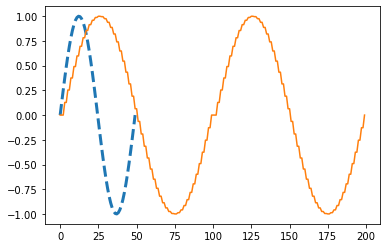

In [76]:
plt.plot(sim.data[p_stim][-1], lw=3, ls='--')
plt.plot(sim.data[p_proj][-1])
